# New Supplemental Figures

# Setup

## imports

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from tabulate import tabulate
from rna_secstruct import SecStruct
from tqdm import tqdm

from dms_quant_framework.plotting import (
    format_small_plot,
    publication_style_ax,
    publication_scatter,
    publication_line,
    plot_pop_avg_from_row,
)

## load data

In [2]:
REVISION_PATH = "../data/revisions"
DATA_PATH = "../data"

In [3]:
df_nomod_norm_res = pd.read_json(
    f"{REVISION_PATH}/normalized/residues/pdb_library_nomod_normalized_residues.json"
)
df_nomod_norm_res = df_nomod_norm_res.query("ln_r_data > -9")

df_denature_norm_res = pd.read_json(
    f"{REVISION_PATH}/normalized/residues/pdb_library_denature_normalized_residues.json"
)
df_denature_norm_res = df_denature_norm_res.query("ln_r_data > -9")

df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")

df_res = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_res["ln_r_data"] = np.log(df_res["r_data"])
df_res["ln_r_data"] = df_res["ln_r_data"].replace(-np.inf, -9.8)
df_res = df_res.query("ln_r_data > -9")

df_avg = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_avg.json")

df_denature_res = pd.read_json(
    f"{REVISION_PATH}/dif_threshold/residues/pdb_library_denature_residues_2000.json"
)
df_denature_res["ln_r_data"] = df_denature_res["ln_r_data"].replace(-np.inf, -9.8)

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
dfs = []
for fn in glob.glob(
    f"{REVISION_PATH}/dif_threshold/residues/pdb_library_1_residues_*.json"
):
    if "avg" in fn:
        continue
    df = pd.read_json(fn)
    with np.errstate(divide="ignore"):
        df["ln_r_data"] = np.log(df["r_data"])
    df["ln_r_data"] = df["ln_r_data"].replace(-np.inf, -9.8)
    df = df.query("r_data_outlier == False").copy()
    df["num_aligned"] = int(fn.split("_")[-1].split(".")[0])
    dfs.append(df)
df_cov_threshold = pd.concat(dfs)

## Extra Functions

In [5]:
def calculate_subplot_coordinates(
    fig_size_inches, subplot_layout, subplot_size_inches, spacing=None
):
    """
    Calculate subplot coordinates for matplotlib subplots with exact subplot sizes.

    Parameters:
    -----------
    fig_size_inches : tuple
        Figure size as (width, height) in inches
    subplot_layout : tuple
        Number of subplots as (rows, columns)
    subplot_size_inches : tuple
        Exact size of each subplot as (width, height) in inches
    spacing : dict, optional
        Spacing parameters as {'hspace': float, 'wspace': float, 'margins': dict}
        - hspace: horizontal spacing between subplots in inches
        - wspace: vertical spacing between subplots in inches
        - margins: {'left': float, 'right': float, 'top': float, 'bottom': float} in inches
        Defaults to 0.5 inch spacing and 0.75 inch margins

    Returns:
    --------
    list
        List of tuples, each containing (left, bottom, width, height) coordinates
        in figure-relative units (0-1) for each subplot

    Raises:
    -------
    Warning if subplots won't fit in the specified figure size
    """
    import warnings

    # Default spacing if not provided
    if spacing is None:
        spacing = {
            "hspace": 0.5,  # horizontal spacing in inches
            "wspace": 0.5,  # vertical spacing in inches
            "margins": {"left": 0.75, "right": 0.75, "top": 0.75, "bottom": 0.75},
        }

    fig_width, fig_height = fig_size_inches
    rows, cols = subplot_layout
    subplot_width, subplot_height = subplot_size_inches

    # Calculate total space needed
    total_subplot_width = cols * subplot_width
    total_subplot_height = rows * subplot_height

    total_hspace = (cols - 1) * spacing["hspace"]
    total_wspace = (rows - 1) * spacing["wspace"]

    total_margins_width = spacing["margins"]["left"] + spacing["margins"]["right"]
    total_margins_height = spacing["margins"]["top"] + spacing["margins"]["bottom"]

    required_width = total_subplot_width + total_hspace + total_margins_width
    required_height = total_subplot_height + total_wspace + total_margins_height

    # Check if subplots fit and issue warnings
    if required_width > fig_width:
        warnings.warn(
            f"Subplots won't fit horizontally! Required width: {required_width:.2f}\", "
            f'Figure width: {fig_width:.2f}". Consider increasing figure width or '
            f"reducing subplot width/spacing."
        )

    if required_height > fig_height:
        warnings.warn(
            f"Subplots won't fit vertically! Required height: {required_height:.2f}\", "
            f'Figure height: {fig_height:.2f}". Consider increasing figure height or '
            f"reducing subplot height/spacing."
        )

    # Calculate coordinates even if they don't fit (for debugging)
    coordinates = []

    # Convert inches to figure-relative coordinates
    for row in range(rows):
        for col in range(cols):
            # Calculate position in inches
            left_inches = spacing["margins"]["left"] + col * (
                subplot_width + spacing["hspace"]
            )
            bottom_inches = spacing["margins"]["bottom"] + (rows - 1 - row) * (
                subplot_height + spacing["wspace"]
            )

            # Convert to figure-relative coordinates (0-1)
            left_rel = left_inches / fig_width
            bottom_rel = bottom_inches / fig_height
            width_rel = subplot_width / fig_width
            height_rel = subplot_height / fig_height

            coordinates.append((left_rel, bottom_rel, width_rel, height_rel))

    return coordinates

In [6]:
def add_legend(ax, labels, loc="upper right"):
    handles = []
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for label, color in zip(labels, colors):
        patch = mlines.Line2D([], [], color=color, lw=0.5, label=label)
        handles.append(patch)
    arial_font = {"family": "Arial", "size": 5}

    legend = ax.legend(
        handles=handles,
        frameon=False,
        loc=loc,
        handlelength=1.0,
        handleheight=0.01,
        handletextpad=0.25,
        borderaxespad=-0.2,  # as close as possible to axes
        prop=arial_font,
        labelspacing=0.2,  # reduce space between lines in legend
    )
    return legend

In [49]:
def add_subplot_labels(fig, coords_list, fig_size):
    letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    for i, coords in enumerate(coords_list):
        fig.text(
            coords[0] - 0.4 / fig_size[0],
            coords[1] + 1.3 / fig_size[1],
            letters[i],
            fontsize=12,
            weight="bold",
            fontname="Arial",
        )

In [7]:
def get_second_stack_cv_df(df):
    """
    Process input dataframe to compute coefficient of variation (CV)
    for second stack, and return combined results.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing columns:
        ['m_sequence', 'r_loc_pos', 'm_second_flank_bp_5p', 'm_second_flank_bp_3p',
         'm_token', 'likely_pair', 'm_flank_bp_5p', 'm_flank_bp_3p',
         'p5_res', 'p3_res', 'r_stack', 'ln_r_data', 'r_data', 'r_type']
    randomized_csv : str
        Path to store/reuse randomized CV results.

    Returns
    -------
    df_all : pd.DataFrame
        Combined dataframe with CV values and data_type labels.
    """
    df = df.copy()
    df["r_type"] = df["r_type"].replace("Flank-WC", "WC")

    # Aggregate per second stack
    df_second_stack = (
        df.groupby(
            ["m_sequence", "r_loc_pos", "m_second_flank_bp_5p", "m_second_flank_bp_3p"]
        )
        .agg(
            m_token=("m_token", "first"),
            likely_pair=("likely_pair", "first"),
            m_flank_bp_5p=("m_flank_bp_5p", "first"),
            m_flank_bp_3p=("m_flank_bp_3p", "first"),
            p5_res=("p5_res", "first"),
            p3_res=("p3_res", "first"),
            r_stack=("r_stack", "first"),
            mean_ln_r_data=("ln_r_data", "mean"),
            std_ln_r_data=("ln_r_data", "std"),
            cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
            count=("ln_r_data", "count"),
            r_type=("r_type", "first"),
            num_aligned=("num_aligned", "first"),
        )
        .reset_index()
    )

    # CV for all data
    df_cv = (
        df.groupby(["m_sequence", "r_loc_pos"])
        .agg(
            cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
            r_type=("r_type", "first"),
            num_aligned=("num_aligned", "first"),
            count=("ln_r_data", "count"),
        )
        .reset_index()
    )
    df_cv = df_cv.query("count >= 5").copy()
    df_cv["data_type"] = "all"

    # Second stack subset make sure there are at least 5 entries or CV will be really low
    df_second_stack_cv = df_second_stack.query("count >= 5").copy()
    df_second_stack_cv["data_type"] = "Second Stack"

    # Combine results
    df_all = pd.concat([df_second_stack_cv, df_cv]).reset_index(drop=True)

    return df_all

In [8]:
def fit_logistic_regression(df):
    df = df.copy()
    df = df.query("r_type == 'Flank-WC' or r_type == 'NON-WC'").copy()
    df["r_type_simple"] = df["r_type"].replace("Flank-WC", "WC")
    df["r_type_binary"] = df["r_type_simple"].apply(lambda x: 1 if x == "WC" else 0)
    model = LogisticRegression()
    model.fit(df[["ln_r_data"]], df["r_type_binary"])
    # Compute probabilities for the original data
    df["prob_WC"] = model.predict_proba(df[["ln_r_data"]])[:, 1]
    # Display the probabilities
    df.sort_values("prob_WC", ascending=False)[
        ["ln_r_data", "r_type_simple", "prob_WC"]
    ]
    # Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
    df["abs_diff"] = (df["prob_WC"] - 0.50).abs()
    # Find the index of the minimum difference
    min_index = df["abs_diff"].idxmin()
    # Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
    closest_row = df.loc[min_index]
    return closest_row["ln_r_data"]

In [9]:
def plot_flank_wc_non_wc_overlap_with_threshold(df, ax, threshold=-5.45):
    # Plot histogram with two colors
    ax.hist(
        df.query("r_type == 'Flank-WC'")["ln_r_data"],
        bins=50,
        color="tab:blue",
        alpha=0.7,
    )
    ax.hist(
        df.query("r_type == 'NON-WC'")["ln_r_data"],
        bins=50,
        color="tab:orange",
        alpha=0.7,
    )

    # Add vertical line at threshold
    ax.axvline(x=threshold, color="black", linestyle="--", linewidth=0.75)
    ax.set_ylabel("Count (×10³)", labelpad=2)
    return ax

In [10]:
def compute_distribution_splits(df, threshold, column="reac_ratio"):
    # Extract data
    blue = df.query("r_type == 'Flank-WC'")[column].dropna()
    orange = df.query("r_type == 'NON-WC'")[column].dropna()

    # Percentage of orange (NON-WC) to the left of threshold
    orange_left_pct = np.mean(orange < threshold) * 100

    # Percentage of blue (Flank-WC) to the right of threshold
    blue_right_pct = np.mean(blue > threshold) * 100

    return orange_left_pct, blue_right_pct

In [11]:
def get_avg_reference_hairpin_reactivity_from_row(row):
    # Create an object from sequence and structure
    struct = SecStruct(row["sequence"], row["structure"])

    # Extract hairpin motifs from the object
    hairpins = struct.get_hairpins()
    if len(hairpins) == 0:
        print(f"Warning: No hairpins found for {row['name']}")
        return None

    hairpin = hairpins[0]
    pos1 = hairpins[0].positions[2]
    pos2 = hairpins[0].positions[5]
    return (row["data"][pos1] + row["data"][pos2]) / 2

In [ ]:
def plot_flank_wc_nonwc_overlap_with_percentages(df, ax):
    """
    Plots the overlap of Flank-WC and Non-WC distributions with threshold and annotates percentages.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data to plot.
    ax : matplotlib.axes.Axes
        The axes on which to plot.
    """
    threshold = fit_logistic_regression(df)
    plot_flank_wc_non_wc_overlap_with_threshold(df, ax, threshold)
    ax.set_yticks([0, 5000, 10000], labels=["0", "5", "10"])
    # add_legend(ax, ["Flank-WC", "Non-WC"])
    orange_left, blue_right = compute_distribution_splits(
        df, threshold, column="ln_r_data"
    )
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

    # Add orange_left in top left, blue_right in top right, both bold Arial and colored
    ax.text(
        0.01,
        0.98,
        f"{orange_left:.2f}%",
        transform=ax.transAxes,
        fontsize=5,
        fontweight="bold",
        fontname="Arial",
        color="tab:orange",
        va="top",
        ha="left",
    )
    ax.text(
        0.99,
        0.98,
        f"{blue_right:.2f}%",
        transform=ax.transAxes,
        fontsize=5,
        fontweight="bold",
        fontname="Arial",
        color="tab:blue",
        va="top",
        ha="right",
    )

# Figures

## Supplemental Figure S7 – Median CV ratio (WC/Non-WC) for different data groupings

### Prepare the data this is the same as figure 1h in the main paper

In [13]:
# Group the data and calculate statistics
df_2000_res = df_cov_threshold.query("num_aligned == 2000").reset_index()
df_second_stack = (
    df_2000_res.groupby(
        ["m_sequence", "r_loc_pos", "m_second_flank_bp_5p", "m_second_flank_bp_3p"]
    )
    .agg(
        m_token=("m_token", "first"),
        likely_pair=("likely_pair", "first"),
        m_flank_bp_5p=("m_flank_bp_5p", "first"),
        m_flank_bp_3p=("m_flank_bp_3p", "first"),
        p5_res=("p5_res", "first"),
        p3_res=("p3_res", "first"),
        r_stack=("r_stack", "first"),
        mean_ln_r_data=("ln_r_data", "mean"),
        std_ln_r_data=("ln_r_data", "std"),
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        count=("ln_r_data", "count"),
        r_type=("r_type", "first"),
    )
    .reset_index()
)

In [14]:
df_sub = pd.read_csv(f"{REVISION_PATH}/cv_csvs/randomized_cvs.csv")

In [15]:
df_cv = (
    df_2000_res.groupby(["m_sequence", "r_loc_pos"])
    .agg(
        cv_r_data=("r_data", lambda x: np.std(x) / np.mean(x)),
        r_type=("r_type", "first"),
    )
    .reset_index()
)
df_cv["data_type"] = "None"
df_second_stack_cv = df_second_stack.query("count >= 5").copy()
df_second_stack_cv["data_type"] = "Second Stack"
df_sub["data_type"] = "Random"
df_all = pd.concat([df_second_stack_cv, df_cv, df_sub]).reset_index(drop=True)

In [16]:
print(
    "average no group WC: "
    + str(df_cv.query("r_type == 'Flank-WC'")["cv_r_data"].mean())
)
print(
    "average with second WC grouping : "
    + str(df_second_stack_cv.query("r_type == 'Flank-WC'")["cv_r_data"].mean())
)
print(
    "average with random grouping: "
    + str(df_sub.query("r_type == 'Flank-WC'")["cv_r_data"].mean())
)
print(
    "average no group NON-WC: "
    + str(df_cv.query("r_type == 'NON-WC'")["cv_r_data"].mean())
)
print(
    "average with second NON-WC grouping : "
    + str(df_second_stack_cv.query("r_type == 'NON-WC'")["cv_r_data"].mean())
)
print(
    "average with random grouping: "
    + str(df_sub.query("r_type == 'NON-WC'")["cv_r_data"].mean())
)

average no group WC: 0.4248140744670936
average with second WC grouping : 0.33967051908293167
average with random grouping: 0.37329936740912867
average no group NON-WC: 0.29662828917958667
average with second NON-WC grouping : 0.22321748277691733
average with random grouping: 0.26921674157402614


### Applying bootstrap algorithm to see if the ratios are significantly different or not

In [17]:
# Create median dataframe
median_df = (
    df_all.groupby(["r_type", "data_type"])["cv_r_data"]
    .median()
    .reset_index()
    .rename(columns={"cv_r_data": "median_cv"})
)
print(median_df)

     r_type     data_type  median_cv
0  Flank-WC          None   0.412337
1  Flank-WC        Random   0.360719
2  Flank-WC  Second Stack   0.323507
3    NON-WC          None   0.281566
4    NON-WC        Random   0.252336
5    NON-WC  Second Stack   0.208480
6        WC          None   0.419006
7        WC  Second Stack   0.389617


In [18]:
# Calculate WC / NON-WC median CV ratios for each data_type
ratios = (
    median_df.pivot(index="data_type", columns="r_type", values="median_cv")
    .reset_index()
    .assign(median_ratio_WC_vs_NON_WC=lambda d: d["Flank-WC"] / d["NON-WC"])
)
print("Median CV ratios (WC / NON-WC):")
print(ratios[["data_type", "median_ratio_WC_vs_NON_WC"]])

Median CV ratios (WC / NON-WC):
r_type     data_type  median_ratio_WC_vs_NON_WC
0               None                   1.464442
1             Random                   1.429521
2       Second Stack                   1.551738


In [19]:
def bootstrap_ratio(df, group_name, n_boot=5000):
    wc = df.query("r_type == 'Flank-WC' and data_type == @group_name")[
        "cv_r_data"
    ].values
    non_wc = df.query("r_type == 'NON-WC' and data_type == @group_name")[
        "cv_r_data"
    ].values

    ratios = []
    for _ in tqdm(range(n_boot)):
        wc_sample = np.random.choice(wc, size=len(wc), replace=True)
        non_wc_sample = np.random.choice(non_wc, size=len(non_wc), replace=True)
        ratio = np.median(wc_sample) / np.median(non_wc_sample)
        ratios.append(ratio)

    return np.array(ratios)


# Bootstrap for Random and Second Stack
ratios_random = bootstrap_ratio(df_all, "Random")
ratios_stack = bootstrap_ratio(df_all, "Second Stack")

# Compare to the baseline value from "None"
baseline_ratio = 1.464442

# 95% confidence intervals
ci_random = np.percentile(ratios_random, [0.5, 99.5])
ci_stack = np.percentile(ratios_stack, [0.5, 99.5])

print(
    f"Random 99% CI: {ci_random}, contains baseline? {ci_random[0] <= baseline_ratio <= ci_random[1]}"
)
print(
    f"Second Stack 99% CI: {ci_stack}, contains baseline? {ci_stack[0] <= baseline_ratio <= ci_stack[1]}"
)

100%|██████████| 5000/5000 [00:02<00:00, 2009.55it/s]

Random 99% CI: [1.4081252 1.4528629], contains baseline? False
Second Stack 99% CI: [1.52514297 1.57978898], contains baseline? False


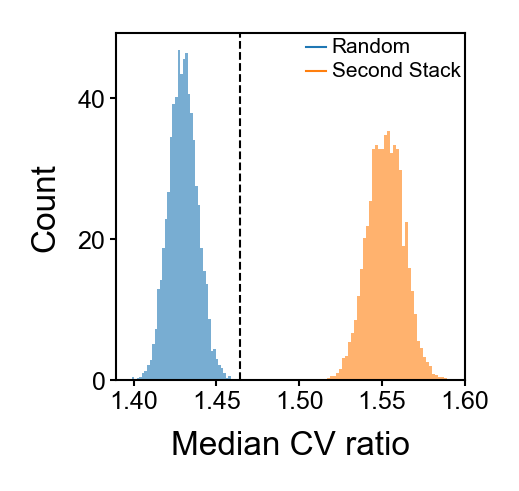

In [20]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), dpi=300)
import matplotlib.lines as mlines

wc_patch = mlines.Line2D([], [], color="#1f77b4", lw=0.5, label="Random")
nonwc_patch = mlines.Line2D([], [], color="#ff7f0e", lw=0.5, label="Second Stack")

ax.hist(
    ratios_random, bins=40, alpha=0.6, label="Random", density=True, color="#1f77b4"
)
ax.hist(
    ratios_stack,
    bins=40,
    alpha=0.6,
    label="Second Stack",
    density=True,
    color="#ff7f0e",
)

ax.axvline(
    baseline_ratio,
    color="black",
    linestyle="--",
    linewidth=0.5,
)

ax.set_xlabel("Median CV ratio")
ax.set_ylabel("Count")
ax.set_xticks([1.40, 1.45, 1.50, 1.55, 1.60])

# Make legend with Arial font and right up against the axes, and reduce vertical spacing
arial_font = {"family": "Arial", "size": 5}

legend = ax.legend(
    handles=[wc_patch, nonwc_patch],
    frameon=False,
    loc="upper right",
    handlelength=1.0,
    handleheight=0.01,
    handletextpad=0.25,
    borderaxespad=-0.2,  # as close as possible to axes
    prop=arial_font,
    labelspacing=0.2,  # reduce space between lines in legend
)

publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

## Supplemental Figure S6: CV for Flank-WC and non-WC at different coverage thresholds

### Sub plots

In [21]:
dfs = []
for num_aligned, g in df_cov_threshold.groupby("num_aligned"):
    dfs.append(get_second_stack_cv_df(g))
df_cv_all = pd.concat(dfs)

In [22]:
summary = (
    df_cv_all.groupby(["num_aligned", "r_type", "data_type"])
    .agg(
        cv_r_data=("cv_r_data", "mean"),
        cv_r_data_std=("cv_r_data", "std"),
        count=("cv_r_data", "count"),
    )
    .reset_index()
)

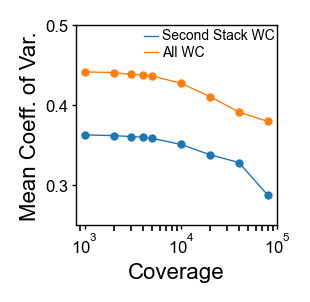

In [23]:
def plot_wc_cv_vs_coverage(df, ax):
    summary_1 = df.query("data_type == 'Second Stack' and r_type == 'WC'")
    summary_2 = df.query("data_type == 'all' and r_type == 'WC'")
    ax.plot(
        summary_1["num_aligned"],
        summary_1["cv_r_data"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="Second Stack",
    )
    ax.plot(
        summary_2["num_aligned"],
        summary_2["cv_r_data"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="All",
    )
    ax.set_xlabel("Coverage", labelpad=2)
    ax.set_ylabel("Mean Coeff. of Var.", labelpad=2)
    ax.set_ylim(0.25, 0.5)
    ax.set_xscale("log")
    ax.set_xticks([1000, 10000, 100000])
    add_legend(ax, ["Second Stack WC", "All WC"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(1, 1, figsize=(1.3, 1.3), dpi=200)
plot_wc_cv_vs_coverage(summary, ax)

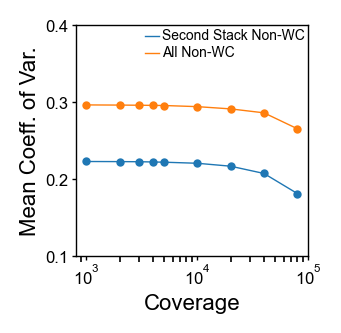

In [24]:
def plot_nonwc_cv_vs_coverage(df, ax):
    summary_1 = df.query("data_type == 'Second Stack' and r_type == 'NON-WC'")
    summary_2 = df.query("data_type == 'all' and r_type == 'NON-WC'")
    ax.plot(
        summary_1["num_aligned"],
        summary_1["cv_r_data"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="Second Stack",
    )
    ax.plot(
        summary_2["num_aligned"],
        summary_2["cv_r_data"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="All",
    )
    ax.set_xlabel("Coverage", labelpad=2)
    ax.set_ylabel("Mean Coeff. of Var.", labelpad=2)
    ax.set_xscale("log")
    ax.set_xticks([1000, 10000, 100000])
    ax.set_ylim(0.10, 0.4)
    add_legend(ax, ["Second Stack Non-WC", "All Non-WC"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=200)
plot_nonwc_cv_vs_coverage(summary, ax)

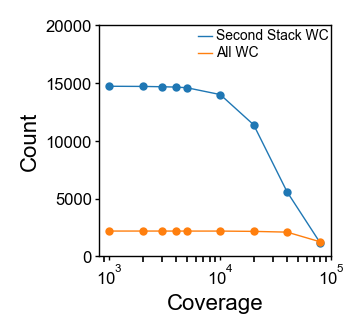

In [25]:
def plot_wc_count_vs_coverage(df, ax):
    summary_1 = df.query("data_type == 'Second Stack' and r_type == 'WC'")
    summary_2 = df.query("data_type == 'all' and r_type == 'WC'")
    ax.plot(
        summary_1["num_aligned"],
        summary_1["count"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="Second Stack",
    )
    ax.plot(
        summary_2["num_aligned"],
        summary_2["count"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="All",
    )
    ax.set_xlabel("Coverage", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_xscale("log")
    ax.set_xticks([1000, 10000, 100000])
    ax.set_ylim(0, 20000)
    add_legend(ax, ["Second Stack WC", "All WC"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=200)
plot_wc_count_vs_coverage(summary, ax)

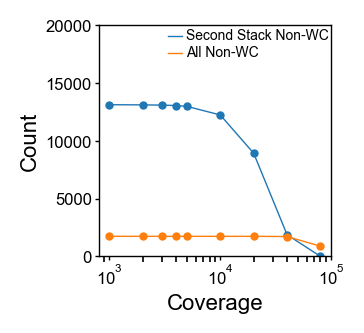

In [26]:
def plot_nonwc_count_vs_coverage(df, ax):
    summary_1 = df.query("data_type == 'Second Stack' and r_type == 'NON-WC'")
    summary_2 = df.query("data_type == 'all' and r_type == 'NON-WC'")
    ax.plot(
        summary_1["num_aligned"],
        summary_1["count"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="Second Stack",
    )
    ax.plot(
        summary_2["num_aligned"],
        summary_2["count"],
        lw=0.5,
        marker="o",
        markersize=2,
        label="All",
    )
    ax.set_xlabel("Coverage", labelpad=2)
    ax.set_ylabel("Count", labelpad=2)
    ax.set_xscale("log")
    ax.set_xticks([1000, 10000, 100000])
    ax.set_ylim(0, 20000)
    add_legend(ax, ["Second Stack Non-WC", "All Non-WC"])
    publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)


# Example usage:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5), dpi=200)
plot_nonwc_count_vs_coverage(summary, ax)

### full figure

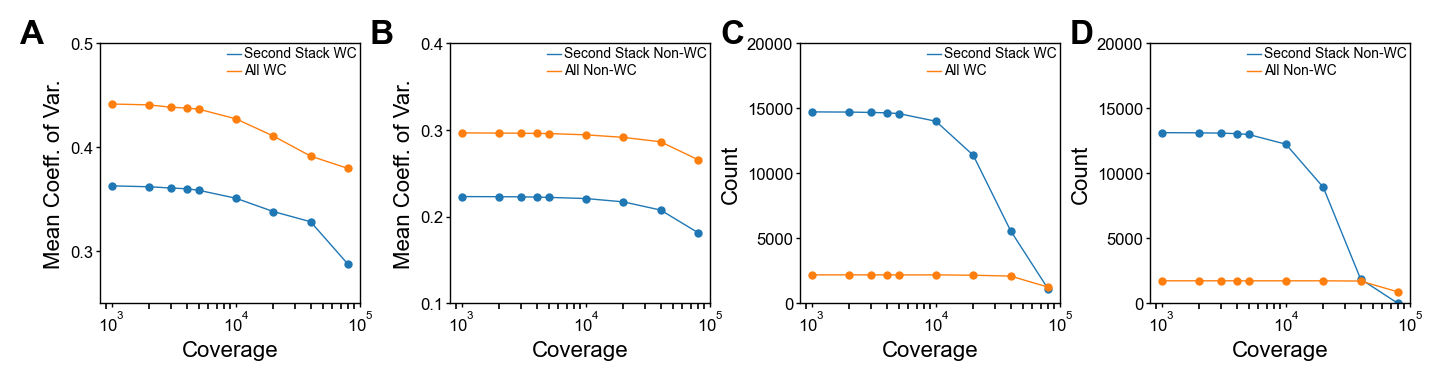

In [51]:
fig_size = (7, 6)
layout = (1, 4)
subplot_size = (1.3, 1.3)
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
ax1 = fig.add_axes(coords_list[0])
plot_wc_cv_vs_coverage(summary, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_nonwc_cv_vs_coverage(summary, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_wc_count_vs_coverage(summary, ax3)

ax4 = fig.add_axes(coords_list[3])
plot_nonwc_count_vs_coverage(summary, ax4)
add_subplot_labels(fig, coords_list, fig_size)

## Supplemental Figure S9 – The reactivity distribution for Flank-WC pairs and non-WC under denaturing conditions

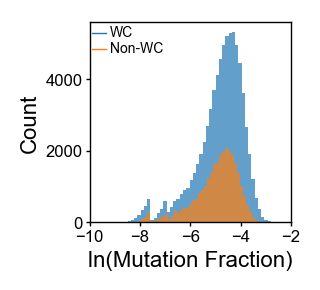

In [28]:
fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)

ax.hist(
    df_denature_res.query(
        "(r_type == 'WC' or r_type == 'Flank-WC') and ln_r_data > -9"
    )["ln_r_data"],
    bins=50,
    alpha=0.7,
    label="Flank-WC",
)
ax.hist(
    df_denature_res.query("r_type == 'NON-WC' and ln_r_data != -9.8")["ln_r_data"],
    bins=50,
    alpha=0.7,
    label="NON-WC",
)
ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
ax.set_ylabel("Count", labelpad=2)
ax.set_xlim(-10, -2)
ax.set_xticks([-10, -8, -6, -4, -2])
add_legend(ax, ["WC", "Non-WC"], loc="upper left")
publication_style_ax(ax, fsize=8, ytick_size=6, xtick_size=6)

## Supplemental Figure S10 – Non-WC and WC overlaps with different normalization methods

### Normalizing with denatured reactivity

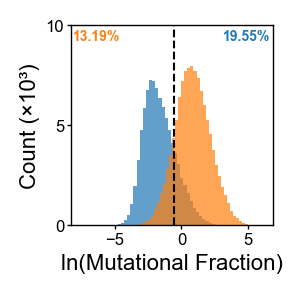

In [ ]:
fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_denature_norm_res, ax)

### Normalizing by averaging

In [ ]:
df_res_norm_by_avg = df_res.copy()
df_res_norm_by_avg["norm_r_data"] = df_res_norm_by_avg["r_data"]

for construct, g in df_res.groupby("constructs"):
    row = df_construct.query("name == @construct").iloc[0]
    avg = np.mean(row["data"])
    df_res_norm_by_avg.loc[g.index, "norm_r_data"] = g["r_data"] / avg

df_res_norm_by_avg["ln_norm_r_data"] = np.log(df_res_norm_by_avg["norm_r_data"])
df_res_norm_by_avg.loc[
    np.isinf(df_res_norm_by_avg["ln_norm_r_data"]), "ln_norm_r_data"
] = -9.8
df_res_norm_by_avg = df_res_norm_by_avg.query("ln_norm_r_data > -9")
df_res_norm_by_avg["ln_r_data"] = df_res_norm_by_avg["ln_norm_r_data"]

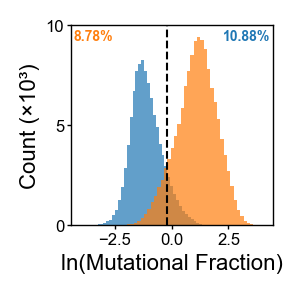

In [ ]:
fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_avg, ax)

### Normalizing with reference hairpin

In [ ]:
df_res_norm_by_ref_hp = df_res.copy()
df_res_norm_by_ref_hp["norm_r_data"] = df_res_norm_by_ref_hp["r_data"]

for construct, g in df_res.groupby("constructs"):
    row = df_construct.query("name == @construct").iloc[0]
    ref_a_avg = get_avg_reference_hairpin_reactivity_from_row(row)
    df_res_norm_by_ref_hp.loc[g.index, "norm_r_data"] = g["r_data"] / ref_a_avg

df_res_norm_by_ref_hp["ln_norm_r_data"] = np.log(df_res_norm_by_ref_hp["norm_r_data"])
df_res_norm_by_ref_hp.loc[
    np.isinf(df_res_norm_by_ref_hp["ln_norm_r_data"]), "ln_norm_r_data"
] = -9.8
df_res_norm_by_ref_hp = df_res_norm_by_ref_hp.query("ln_norm_r_data > -9")
df_res_norm_by_ref_hp["ln_r_data"] = df_res_norm_by_ref_hp["ln_norm_r_data"]

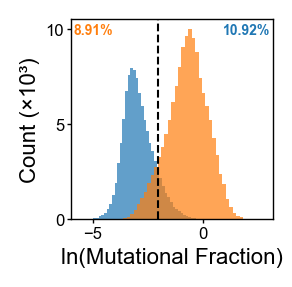

In [ ]:
fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_ref_hp, ax)

### Normalizing with nomod reactivity

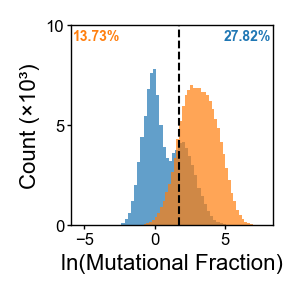

In [ ]:
fig, ax = plt.subplots(figsize=(1.3, 1.3), dpi=200)
plot_flank_wc_nonwc_overlap_with_percentages(df_nomod_norm_res, ax)

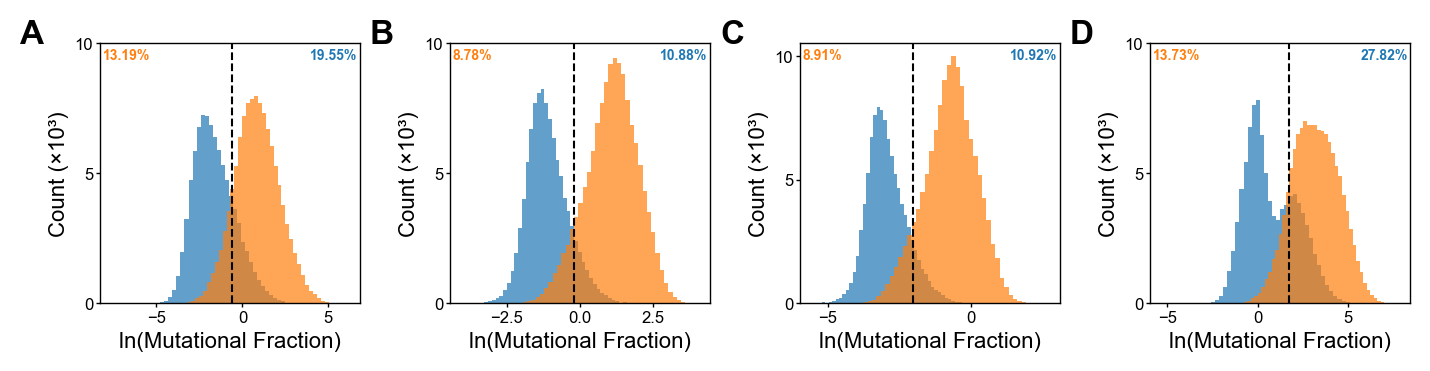

In [50]:
fig_size = (7, 6)
layout = (1, 4)
subplot_size = (1.3, 1.3)
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.70},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)
ax1 = fig.add_axes(coords_list[0])
plot_flank_wc_nonwc_overlap_with_percentages(df_denature_norm_res, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_avg, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_flank_wc_nonwc_overlap_with_percentages(df_res_norm_by_ref_hp, ax3)

ax4 = fig.add_axes(coords_list[3])
plot_flank_wc_nonwc_overlap_with_percentages(df_nomod_norm_res, ax4)
add_subplot_labels(fig, coords_list, fig_size)